# Animal Shelter Data Analysis


This project analyzes animal shelter data by combining two public datasets: data from Louisville Metro Animal Services and from Sonoma County Animal Services. The Analysis portion has "Questions for Further Study" that go beyond the scope of this project but are meant for critical thinking and inspiration for further work.

## 1. Load and Clean Data

First, let’s create dataframes by reading in the two CSV files. We’ll remove columns that won’t be used, and since many of the columns have similar but not identical names, we’ll rename them, too. We’ll also remove rows with blank values.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


lou_df = pd.read_csv(r"Data\Louisville_Data.csv")
sonoma_df = pd.read_csv(r"Data\Sonoma_County_Data.csv")

# delete unused columns
lou_df = lou_df.drop(columns=['kennel', 'surreason', 'bites', 'sourcezipcode', 'ObjectId'])
sonoma_df = sonoma_df.drop(columns=['Name', 'Date Of Birth', 'Impound Number', 'Kennel Number', 
                        'Intake Condition', 'Outcome Condition', 'Intake Jurisdiction', 
                        'Outcome Jurisdiction', 'Location', 'Count'])

# rename columns so we can merge with Sonoma later
lou_df = lou_df.rename(columns={'animaltype': 'Type', 'breed': 'Breed', 'color': 'Color', 
                                'sex': 'Sex', 'petsize': 'Size', 'animalid': 'Animal ID',
                                'indate': 'Intake Date', 'outdate': 'Outcome Date', 'intype': 'Intake Type',
                                'insubtype': 'Intake Subtype', 'outtype': 'Outcome Type', 'outsubtype': 'Outcome Subtype',
                                'jurisdiction': 'Outcome Zip Code'})

# removes rows with blank values
lou_df = lou_df.dropna()
sonoma_df = sonoma_df.dropna()

lou_df.head()


,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed
0,A492190,40243,STRAY,FIELD,2021/09/02 00:00:00,ADOPTION,REFERRAL,2021/09/07 00:00:00,DOG,N,LARGE,BL BRINDLE,PIT BULL / MIX
1,A497115,40215,OWNER SUR,EUTH REQ,2019/01/11 00:00:00,EUTH,REQUESTED,2019/01/11 00:00:00,DOG,M,PUPPY,BLACK / RED,DOBERMAN PINSCH
2,A307550,40291,STRAY,OTC,2020/01/10 00:00:00,RTO,IN KENNEL,2020/01/10 00:00:00,DOG,N,MED,BROWN,BASSET HOUND / BASSET HOUND
3,A331757,40222,CONFISCATE,OWNER DIED,2020/09/21 00:00:00,EUTH,INHUMANE,2020/09/21 00:00:00,DOG,N,LARGE,YELLOW,LABRADOR RETR
4,A571544,40216,STRAY,OTC,2022/11/14 00:00:00,RTO,IN KENNEL,2022/11/19 00:00:00,DOG,M,LARGE,GOLD,GOLDEN RETR


Next, let’s look at the datatypes for each dataset to make sure they line up with what we need. We’ll start with Louisville’s data.

In [2]:
lou_df.dtypes

Animal ID           object
Outcome Zip Code    object
Intake Type         object
Intake Subtype      object
Intake Date         object
Outcome Type        object
Outcome Subtype     object
Outcome Date        object
Type                object
Sex                 object
Size                object
Color               object
Breed               object
dtype: object

Everything is currently being treated as an object (text), which is good for most of our data, but not for our date columns. We need to change the *Intake Date* and *Outcome Date* columns to the **datetime** datatype. This will also allow us to create a new *Days in Shelter* column, which the Sonoma dataset already has.

In [3]:
lou_df['Intake Date'] = pd.to_datetime(lou_df['Intake Date'], errors='coerce')
lou_df['Outcome Date'] = pd.to_datetime(lou_df['Outcome Date'], errors='coerce')

# Creates a new 'Days in Shelter' column by calculating the difference from Outcome Date and Intake Date
lou_df['Days in Shelter'] = (lou_df['Outcome Date'] - lou_df['Intake Date']).dt.days

lou_df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,N,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SUR,EUTH REQ,2019-01-11,EUTH,REQUESTED,2019-01-11,DOG,M,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OTC,2020-01-10,RTO,IN KENNEL,2020-01-10,DOG,N,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTH,INHUMANE,2020-09-21,DOG,N,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OTC,2022-11-14,RTO,IN KENNEL,2022-11-19,DOG,M,LARGE,GOLD,GOLDEN RETR,5


Louisville’s data is looking much better now. Let’s move to Sonoma’s dataset, starting with checking their datatypes.

In [4]:
sonoma_df.dtypes

Type                 object
Breed                object
Color                object
Sex                  object
Size                 object
Animal ID            object
Intake Date          object
Outcome Date         object
Days in Shelter       int64
Intake Type          object
Intake Subtype       object
Outcome Type         object
Outcome Subtype      object
Outcome Zip Code    float64
dtype: object

Nearly everything is an object; so, we’ll once again need to convert the date columns to **datetime**. Let’s also change the *Outcome Zip Code* from a float into an **integer** (since zip codes don’t use decimals). Sonoma’s data goes back to 2013, but Louisville’s only goes to 2019. Let’s remove the Sonoma rows that precede 2019 to make the data merge cleaner.

In [5]:
sonoma_df['Intake Date'] = pd.to_datetime(sonoma_df['Intake Date'], errors='coerce')
sonoma_df['Outcome Date'] = pd.to_datetime(sonoma_df['Outcome Date'], errors='coerce')
sonoma_df['Outcome Zip Code'] = sonoma_df['Outcome Zip Code'].astype('int')

# remove rows with dates before 2019 (because Louisville's data only goes back to 2019)
sonoma_df = sonoma_df.loc[sonoma_df['Intake Date'] >= pd.to_datetime('2019-01-01')]

sonoma_df.head()

,Type,Breed,Color,Sex,Size,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Outcome Zip Code
0,DOG,MALTESE/POODLE TOY,WHITE,Spayed,TOY,A328255,2023-07-05,2023-08-08,34,STRAY,FIELD,ADOPTION,SCAS WEB,95441
1,CAT,DOMESTIC SH,BLACK,Unknown,KITTN,A420799,2023-09-30,2023-09-30,0,STRAY,OVER THE COUNTER,TRANSFER,PETLUMA PP,94952
2,CAT,DOMESTIC LH,BLACK/WHITE,Neutered,SMALL,A420773,2023-09-29,2023-09-30,1,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_MCHIP,94901
3,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,A420810,2023-09-30,2023-09-30,0,STRAY,OVER THE COUNTER,TRANSFER,HSSC,95407
4,CAT,DOMESTIC SH,ORG TABBY/WHITE,Spayed,KITTN,A417889,2023-05-30,2023-08-08,70,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,95404


Speaking of merging, both datasets have items with the same meaning but are written differently (e.g., Louisville says “OTC” while Sonoma says “Over the Counter”). Since Louisville’s data is generally more abbreviated, let’s change Louisville’s items to match Sonoma’s so that it’s more clear and easy to read.

In [6]:
lou_df['Sex'] = lou_df['Sex'].replace({
    'M' : 'Male',
    'F' : 'Female',
    'N' : 'Neutered',
    'S' : 'Spayed',
    'U' : 'Unknown'
    })

lou_df['Intake Type'] = lou_df['Intake Type'].replace({
    'OWNER SUR' : 'OWNER SURRENDER'
})

lou_df['Intake Subtype'] = lou_df['Intake Subtype'].replace({
    'OTC' : 'OVER THE COUNTER'
})

lou_df['Outcome Type'] = lou_df['Outcome Type'].replace({
    'RTO' : 'RETURN TO OWNER',
    'EUTH' : 'EUTHANIZE',
})

lou_df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,EUTHANIZE,REQUESTED,2019-01-11,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,RETURN TO OWNER,IN KENNEL,2020-01-10,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTHANIZE,INHUMANE,2020-09-21,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,RETURN TO OWNER,IN KENNEL,2022-11-19,DOG,Male,LARGE,GOLD,GOLDEN RETR,5


In [7]:
# print(lou_df.value_counts('Intake Type').head())
# print(sonoma_df.value_counts('Intake Type').head())
# print(lou_df.value_counts('Intake Subtype').head())
# print(sonoma_df.value_counts('Intake Subtype').head())

# print(lou_df.value_counts('Outcome Type'))
# print(sonoma_df.value_counts('Outcome Type')) #lou significant majority Adoption, while sonoma majority is Return to Owner
# print(lou_df.value_counts('Outcome Subtype').head())
# print(sonoma_df.value_counts('Outcome Subtype').head())


# print(lou_df.value_counts('Days in Shelter').head(15)) #almost perfectly in order with 0 days most common, then 1, then 2...
# print(sonoma_df.value_counts('Days in Shelter').head(15))

## 2. Merge and Analysis

Now we’re ready to merge the data using pandas' **concatenate** function.

In [8]:
df = pd.concat([lou_df, sonoma_df], ignore_index=True)

df

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,EUTHANIZE,REQUESTED,2019-01-11,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,RETURN TO OWNER,IN KENNEL,2020-01-10,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTHANIZE,INHUMANE,2020-09-21,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,RETURN TO OWNER,IN KENNEL,2022-11-19,DOG,Male,LARGE,GOLD,GOLDEN RETR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41962,A389577,95446,TRANSFER,PRIV_SHELT,2019-07-20,ADOPTION,WALKIN,2019-07-30,CAT,Neutered,KITTN,WHITE/BLACK,DOMESTIC SH,10
41963,A408062,95476,OWNER SURRENDER,OVER THE COUNTER,2021-12-07,TRANSFER,PETSLIFELN,2022-02-02,CAT,Spayed,SMALL,BRN TABBY,DOMESTIC SH,57
41964,A411802,95407,STRAY,PHONE,2022-05-31,RETURN TO OWNER,OVER THE COUNTER_MCHIP,2022-06-02,DOG,Spayed,TOY,TAN,YORKSHIRE TERR/MIX,2
41965,A394200,95401,STRAY,OVER THE COUNTER,2021-10-29,RETURN TO OWNER,OVER THE COUNTER_WEB,2021-10-29,DOG,Neutered,LARGE,BLACK/WHITE,SIBERIAN HUSKY,0


After all that cleaning, we still have over 41,000 rows of data. But does that mean 41,000 animals were served?

In [9]:
print("Unique animals:", df['Animal ID'].nunique())

Unique animals: 33445


By counting the number of unique Animal ID’s, we see that roughly 33,000 animals were actually served. This means that about 8,000 (41,000 - 33,000) appear multiple times in the dataset, meaning they were served more than once.

Since we looked at unique animals, let’s look at which animal types and breeds were served the most.


In [10]:
print(df.value_counts('Type').head()) 
print(df.value_counts('Breed').head())

Type
DOG       24609
CAT       16050
OTHER       880
RABBIT      264
BIRD         76
Name: count, dtype: int64
Breed
DOMESTIC SH       13327
PIT BULL           4440
DOMESTIC MH        1499
GERM SHEPHERD      1162
PIT BULL / MIX     1068
Name: count, dtype: int64


The significant majority were dogs and cats. But although there were more dogs, the most common breed is the Domestic Shorthair cat.

For our first visualization, let’s show how many animals were taken in per year by looking at the Intake Date column. To make the comparison easier, let’s create a new Indate Year column that extracts the year from the Intake Date.


In [11]:
df.insert(5, 'Intake Year', pd.to_datetime(df['Intake Date']).dt.year)
df.insert(9, 'Outcome Year', pd.to_datetime(df['Outcome Date']).dt.year)

df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Intake Year,Outcome Type,Outcome Subtype,Outcome Date,Outcome Year,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,2021,ADOPTION,REFERRAL,2021-09-07,2021,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,2019,EUTHANIZE,REQUESTED,2019-01-11,2019,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,2020,RETURN TO OWNER,IN KENNEL,2020-01-10,2020,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,2020,EUTHANIZE,INHUMANE,2020-09-21,2020,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,2022,RETURN TO OWNER,IN KENNEL,2022-11-19,2022,DOG,Male,LARGE,GOLD,GOLDEN RETR,5


Before making the visualization, we still need to get value counts for each year. Let’s save that as a new dataframe called indate_df. Then, we can make the line plot.

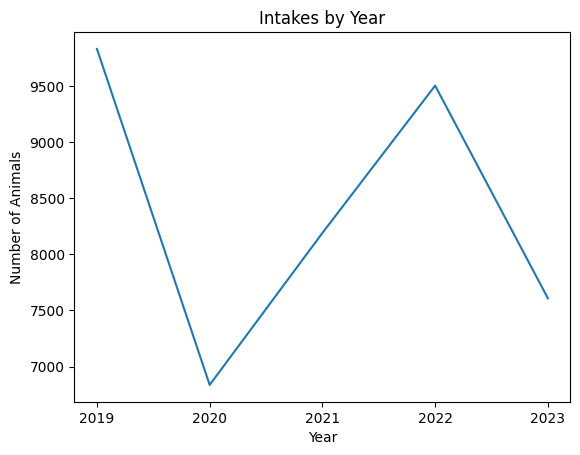

In [12]:
indate_df = df.value_counts('Intake Year').reset_index().sort_values(['Intake Year'])
indate_df.columns = ['Year', 'Count']

#change X axis to only show integers
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(indate_df['Year'], indate_df['Count'])
plt.xlabel('Year')
plt.ylabel('Number of Animals')
plt.title('Intakes by Year')
plt.show()

There was a significant (and understandable) decrease in 2020 due to COVID. The number for 2023 seems lower than expected. Surprisingly, the most recent dates in the data (at the time of creating this study) go to mid-November 2023, meaning that the data–as far as we can tell–is up to date. The difference between 2022 and 2023 looks to be about 2,000.

Questions for further study:
- Why are numbers lower for 2023? Is there a huge backlog that will be entered before the end of the year? How does animal population affect this data? How does *human* population affect this data?
- Should we expect 2024’s numbers to make an incline or continue moving down?

---

For our second visual, let’s see how long the animals typically stayed by using the Days in Shelter column.


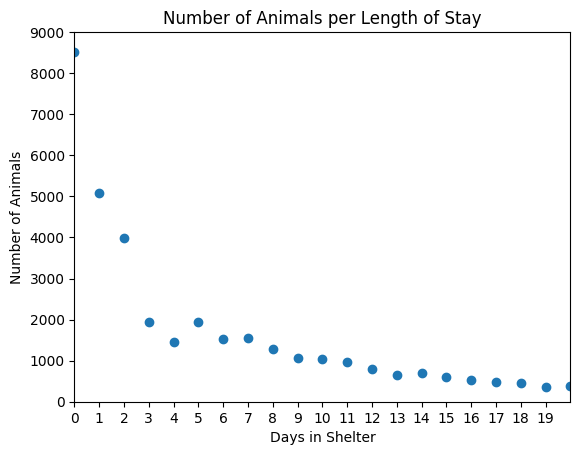

In [13]:
day_shelter_df = df.value_counts('Days in Shelter').reset_index().sort_values(['Days in Shelter'])
day_shelter_df.columns = ['Days', 'Count']

plt.scatter(day_shelter_df['Days'], day_shelter_df['Count'])
plt.rcParams["figure.figsize"] = (20, 3) #makes graph thinner since the default size is too wide
plt.axis((0, 20, 0, 9000))
plt.xticks(range(0, 20))
plt.xlabel('Days in Shelter')
plt.ylabel('Number of Animals')
plt.title('Number of Animals per Length of Stay')
plt.show()

The largest group of animals (about 8,500) were taken in and out on the same day (stayed for 0 days). The data is mostly linear: as the number of days increases, the amount of animals staying that long usually decreases. From day 6 onward, the data typically follows a pattern of remaining around the same place for a day or two, and then moving down a bit–stay a bit, move down a bit, and so on.

Questions for further study: 
- Why are most animals taken in and out on the same day: treating minor injuries, receiving shots/vaccinations?
- Would most euthanized animals be put in this category?
- What other outcomes typically occur on the same day as the intake?

---

Doing a value count of Intake Type, the significant majority of animals are taken in because they’re stray. What happens to them? Let’s make a visual to show that.


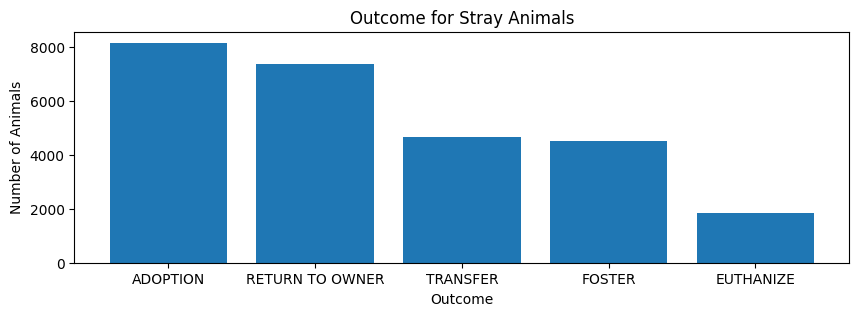

In [14]:
stray_df = df.loc[df['Intake Type'] == 'STRAY']

stray_outcomes = stray_df['Outcome Type'].value_counts().reset_index().head()
stray_outcomes.columns = ['Outcome Type', 'Count']

plt.rcParams["figure.figsize"] = (10, 3)
plt.bar(stray_outcomes['Outcome Type'], stray_outcomes['Count'])
plt.xlabel('Outcome')
plt.ylabel('Number of Animals')
plt.title('Outcome for Stray Animals')
plt.show()

Most stray animals are adopted or returned to their owners.

Questions for further study: 
- The third most likely outcome for stray animals is that they’re transferred to another shelter–so what happens to them *after* they're transferred?
- Are transferred animals more/less likely to be adopted or returned to owners?
- How long does it take for stray animals to be adopted vs. returned to their owners?

## Conclusion

This study fulfills every requirement for the Capstone Project:
1. Read two data files (CSV).
2. Clean data and perform a pandas merge with two datasets. Calculate new values based on the new data set.
3. Make 3 matplotlib visualizations to display data.
4. Utilize a virtual environment and include instructions in your README on how the user should set one up.
5. Annotate your code with markdown cells in Jupyter Notebook, write clear code comments and have a well-written README.md.

The study demonstrates proficiency in using the following tools:
- Python
- pandas
- matplotlib
- Jupyter
- Markdown


In [15]:
#bar graph
#how many of each animal was served?
# animal_count_df = df.value_counts('Type').reset_index()
# animal_count_df.columns = ['Animal', 'Count']
# animal_count_df.sort_values(['Count'])

# plt.bar(animal_count_df['Animal'], animal_count_df['Count'])
# plt.xlabel('Animal')
# plt.ylabel('Count')
# plt.show()

In [16]:
#what are the most common dog breeds in LMAS?

dog_df = df.loc[df['Type'] == 'DOG']

# print(dog_df.value_counts('intype'))
# print(dog_df.value_counts('outtype'))
print(dog_df.value_counts('Breed').head(10))

# explore dog adoption stats
# adopted_dog_df = dog_df.loc[dog_df['outtype'] == 'ADOPTION']
# print(adopted_dog_df.value_counts('outsubtype'))



Breed
PIT BULL               4440
GERM SHEPHERD          1162
PIT BULL / MIX         1068
LABRADOR RETR / MIX     968
LABRADOR RETR           820
CHIHUAHUA SH            808
BEAGLE                  446
GERM SHEPHERD / MIX     432
SIBERIAN HUSKY          419
BOXER / MIX             378
Name: count, dtype: int64
